In [1]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 3
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed 
set_random_seed(2)

from keras import backend as K

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd 
import math as m
import os, glob

Using TensorFlow backend.


In [2]:

RANGE = 51

HYPER_L1_IN = RANGE
EPOCHS = 100
BATCH_SIZE = 32

TEST_SIZE = .19
VAL_SIZE = .0

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [3]:
#LOAD DATASET for ASK
# change column names
#load Dataset for BID
#change column names

cwd = os.getcwd()
source_data = os.path.join(cwd, r'proj_deep/')
filenames = glob.glob(source_data + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S.%f')
DF_EURUSD_ASK = pd.read_csv(filenames[1], parse_dates=['Gmt time'], date_parser=dateparse, index_col=None, header=0)
print(DF_EURUSD_ASK.columns)
DF_EURUSD_ASK.rename(columns={'Gmt time':'timestamp',
                             'Open':'open_ask',
                             'High':'high_ask',
                             'Low':'low_ask',
                             'Close':'close_ask',
                             'Volume':'volume_ask'},
                    inplace=True)
print(DF_EURUSD_ASK.columns)

print(DF_EURUSD_ASK.head())
print(DF_EURUSD_ASK.tail())



EURUSD_ASK_01.01.2004-19.11.2019.csv
EURUSD_Candlestick_1_Hour_ASK_31.07.2018-31.07.2019.csv
EURUSD_Candlestick_1_Hour_BID_31.07.2018-31.07.2019.csv
Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Index(['timestamp', 'open_ask', 'high_ask', 'low_ask', 'close_ask',
       'volume_ask'],
      dtype='object')
            timestamp  open_ask  high_ask  low_ask  close_ask  volume_ask
0 2018-08-01 00:00:00   1.16894   1.16926  1.16885    1.16905   6394.8501
1 2018-08-01 01:00:00   1.16905   1.16914  1.16832    1.16895   7304.5498
2 2018-08-01 02:00:00   1.16896   1.16920  1.16823    1.16854   6709.3501
3 2018-08-01 03:00:00   1.16854   1.16880  1.16799    1.16799   6154.0601
4 2018-08-01 04:00:00   1.16799   1.16833  1.16761    1.16779   5269.6699
               timestamp  open_ask  high_ask  low_ask  close_ask  volume_ask
6246 2019-08-01 19:00:00   1.10854   1.10945  1.10798    1.10930  30454.0801
6247 2019-08-01 20:00:00   1.10928   1.10938  1.10837    1.1085

In [4]:
print(DF_EURUSD_ASK.shape)
#DF_EURUSD_ASK2 = DF_EURUSD_ASK.iloc[3500:]
DF_EURUSD_ASK2 = DF_EURUSD_ASK
print(DF_EURUSD_ASK2.shape)


(6251, 6)
(6251, 6)


In [5]:
#Describe Dataframe ASK

print('Shape: ', DF_EURUSD_ASK2.shape)
print(DF_EURUSD_ASK2.describe())
print(DF_EURUSD_ASK2.head())
#date_series = pd.to_datetime(DF_EURUSD_ASK['timestamp'][0])
DF_EURUSD_ASK2 = DF_EURUSD_ASK2.drop(['timestamp'], axis = 1)
print(DF_EURUSD_ASK2.dtypes)


Shape:  (6251, 6)
          open_ask     high_ask      low_ask    close_ask     volume_ask
count  6251.000000  6251.000000  6251.000000  6251.000000    6251.000000
mean      1.136863     1.137463     1.136255     1.136855   12982.056088
std       0.014978     0.015061     0.014905     0.014978    8909.610064
min       1.102980     1.104150     1.102710     1.102990       5.250000
25%       1.125685     1.126140     1.125130     1.125685    6613.855000
50%       1.135000     1.135680     1.134430     1.134990   11323.240200
75%       1.144675     1.145370     1.143900     1.144655   17256.754850
max       1.179880     1.181540     1.177980     1.179870  252673.546900
            timestamp  open_ask  high_ask  low_ask  close_ask  volume_ask
0 2018-08-01 00:00:00   1.16894   1.16926  1.16885    1.16905   6394.8501
1 2018-08-01 01:00:00   1.16905   1.16914  1.16832    1.16895   7304.5498
2 2018-08-01 02:00:00   1.16896   1.16920  1.16823    1.16854   6709.3501
3 2018-08-01 03:00:00   1.168

In [6]:
#Moving Average  
def MA(df, n): 
    MA = pd.Series(df['close_ask'].rolling(n).mean(), name = 'MA_' + str(n)) 
    df = df.join(MA)  
    return df


In [7]:
DF_EURUSD_ASK_MA25 = MA(DF_EURUSD_ASK2, 25)
print(DF_EURUSD_ASK_MA25)


      open_ask  high_ask  low_ask  close_ask  volume_ask     MA_25
0      1.16894   1.16926  1.16885    1.16905   6394.8501       NaN
1      1.16905   1.16914  1.16832    1.16895   7304.5498       NaN
2      1.16896   1.16920  1.16823    1.16854   6709.3501       NaN
3      1.16854   1.16880  1.16799    1.16799   6154.0601       NaN
4      1.16799   1.16833  1.16761    1.16779   5269.6699       NaN
5      1.16779   1.16821  1.16761    1.16804   8515.1699       NaN
6      1.16805   1.16857  1.16723    1.16821  14354.9902       NaN
7      1.16821   1.16942  1.16770    1.16877  14436.9502       NaN
8      1.16877   1.16905  1.16815    1.16820  11943.6904       NaN
9      1.16820   1.16855  1.16775    1.16831  10390.4805       NaN
10     1.16831   1.16875  1.16807    1.16867  10072.8203       NaN
11     1.16866   1.16880  1.16811    1.16864  11361.8203       NaN
12     1.16862   1.16998  1.16833    1.16903  16363.9697       NaN
13     1.16904   1.16922  1.16763    1.16779  15235.9502      

In [8]:
DF_EURUSD_ASK_MA50 = MA(DF_EURUSD_ASK_MA25, 50)
print(DF_EURUSD_ASK_MA50)

      open_ask  high_ask  low_ask  close_ask  volume_ask     MA_25     MA_50
0      1.16894   1.16926  1.16885    1.16905   6394.8501       NaN       NaN
1      1.16905   1.16914  1.16832    1.16895   7304.5498       NaN       NaN
2      1.16896   1.16920  1.16823    1.16854   6709.3501       NaN       NaN
3      1.16854   1.16880  1.16799    1.16799   6154.0601       NaN       NaN
4      1.16799   1.16833  1.16761    1.16779   5269.6699       NaN       NaN
5      1.16779   1.16821  1.16761    1.16804   8515.1699       NaN       NaN
6      1.16805   1.16857  1.16723    1.16821  14354.9902       NaN       NaN
7      1.16821   1.16942  1.16770    1.16877  14436.9502       NaN       NaN
8      1.16877   1.16905  1.16815    1.16820  11943.6904       NaN       NaN
9      1.16820   1.16855  1.16775    1.16831  10390.4805       NaN       NaN
10     1.16831   1.16875  1.16807    1.16867  10072.8203       NaN       NaN
11     1.16866   1.16880  1.16811    1.16864  11361.8203       NaN       NaN

In [9]:
print(DF_EURUSD_ASK_MA50.shape)
DF_loc = DF_EURUSD_ASK_MA50.iloc[50:]
print(DF_loc)
print(DF_loc.shape)

(6251, 7)
      open_ask  high_ask  low_ask  close_ask  volume_ask     MA_25     MA_50
50     1.15837   1.15883  1.15814    1.15880   6212.9302  1.161234  1.164347
51     1.15880   1.15933  1.15877    1.15910   5643.0000  1.160979  1.164150
52     1.15909   1.15933  1.15893    1.15920   3644.9399  1.160743  1.163963
53     1.15920   1.15952  1.15903    1.15910   4889.7598  1.160517  1.163785
54     1.15909   1.15909  1.15772    1.15784  11832.5801  1.160228  1.163586
55     1.15784   1.15910  1.15622    1.15623  15047.8799  1.159954  1.163350
56     1.15621   1.15795  1.15618    1.15794  13265.4902  1.159746  1.163145
57     1.15794   1.15850  1.15747    1.15753  11351.4805  1.159566  1.162920
58     1.15753   1.15800  1.15727    1.15798   8600.7002  1.159427  1.162715
59     1.15798   1.16107  1.15797    1.15964  17741.5996  1.159322  1.162542
60     1.15963   1.16098  1.15856    1.15953  20201.6699  1.159232  1.162359
61     1.15953   1.15984  1.15605    1.15727  21616.7305  1.159016

In [10]:
DF_Full = DF_loc
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)
print(DF_Full.columns)
print(DF_Full.head(10))

(6201, 7)
Index(['open_ask', 'high_ask', 'low_ask', 'close_ask', 'volume_ask', 'MA_25',
       'MA_50'],
      dtype='object')
   open_ask  high_ask  low_ask  close_ask  volume_ask     MA_25     MA_50
0   1.15837   1.15883  1.15814    1.15880   6212.9302  1.161234  1.164347
1   1.15880   1.15933  1.15877    1.15910   5643.0000  1.160979  1.164150
2   1.15909   1.15933  1.15893    1.15920   3644.9399  1.160743  1.163963
3   1.15920   1.15952  1.15903    1.15910   4889.7598  1.160517  1.163785
4   1.15909   1.15909  1.15772    1.15784  11832.5801  1.160228  1.163586
5   1.15784   1.15910  1.15622    1.15623  15047.8799  1.159954  1.163350
6   1.15621   1.15795  1.15618    1.15794  13265.4902  1.159746  1.163145
7   1.15794   1.15850  1.15747    1.15753  11351.4805  1.159566  1.162920
8   1.15753   1.15800  1.15727    1.15798   8600.7002  1.159427  1.162715
9   1.15798   1.16107  1.15797    1.15964  17741.5996  1.159322  1.162542


In [11]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  6201
Start:  0


In [12]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

(6201, 7)


In [13]:

total = DF_Full.shape[0]
print('Total: ', total)

Total:  6201


In [14]:
#generate the VECTOR Y
close_y = DF_Full['close_ask'].iloc[1:]
close_y.columns = ['close_y']
print(close_y.tail())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)


6196    1.10930
6197    1.10855
6198    1.10833
6199    1.10788
6200    1.10793
Name: close_ask, dtype: float64
(6200,)
6196    1.10855
6197    1.10833
6198    1.10788
6199    1.10793
6200    1.10793
Name: close_ask, dtype: float64
(6201,)


In [15]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.19
count of Val and Test: 1178
end of train:  5023
count val:  0
count test:  1178
end_val 5023


In [16]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print(data_training.shape)
print(data_val.shape)
print(data_test.shape)

data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]

print(data_training_y.shape)
print(data_val_y.shape)
print(data_test_y.shape)

(5023, 7)
(0, 7)
(1178, 7)
(5023,)
(0,)
(1178,)


In [17]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.68133333 0.66812801 0.70502528 ... 0.0245685  0.74818055 0.80645568]
 [0.6877037  0.67543475 0.71439191 ... 0.02231285 0.74417085 0.80327339]
 [0.692      0.67543475 0.71677074 ... 0.01440501 0.74046281 0.80025588]
 ...
 [0.12681481 0.11500804 0.14927148 ... 0.02079022 0.08502709 0.04348585]
 [0.12622222 0.11471577 0.14570324 ... 0.01705699 0.08680569 0.04499137]
 [0.12814815 0.11968435 0.15254237 ... 0.00423239 0.08862199 0.04684259]]


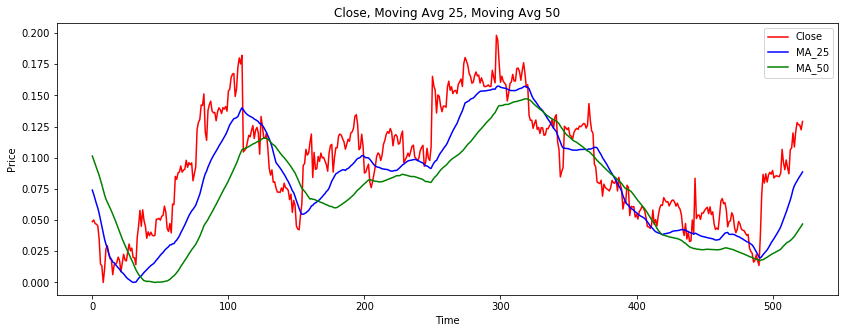

In [18]:




plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[4500:,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[4500:,5], color = 'blue', label = 'MA_25')
pyplot.plot(data_training_array_scaled[4500:,6], color = 'green', label = 'MA_50')
plt.title('Close, Moving Avg 25, Moving Avg 50')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

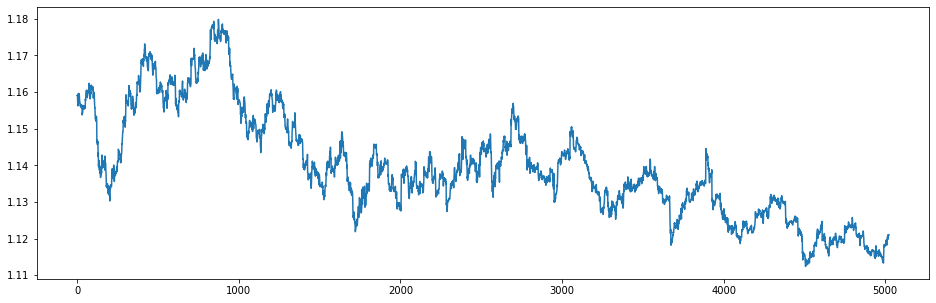

In [19]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [20]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(4972, 51, 7)
(4972,)


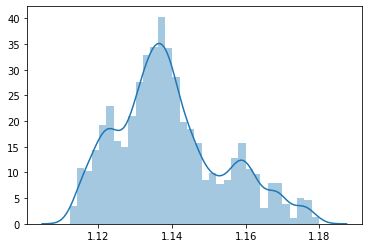

In [21]:
sns.distplot(y_train_np);



In [22]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(51, 7)
(0, 7)
<bound method NDFrame.head of     open_ask  high_ask  low_ask  close_ask  volume_ask     MA_25     MA_50
0    1.11597   1.11599  1.11532    1.11537   9492.2695  1.116054  1.116025
1    1.11536   1.11549  1.11501    1.11508   3658.7000  1.116011  1.115991
2    1.11508   1.11543  1.11507    1.11526   1894.3600  1.115976  1.115966
3    1.11530   1.11575  1.11529    1.11569   3471.3501  1.115952  1.115946
4    1.11570   1.11573  1.11549    1.11556   3952.6299  1.115920  1.115920
5    1.11555   1.11556  1.11518    1.11529   6008.5400  1.115873  1.115889
6    1.11530   1.11541  1.11484    1.11521   8630.7695  1.115837  1.115858
7    1.11521   1.11532  1.11481    1.11520   9619.4297  1.115786  1.115832
8    1.11520   1.11530  1.11489    1.11506   8379.1104  1.115746  1.115800
9    1.11505   1.11506  1.11484    1.11494   6395.2100  1.115695  1.115769
10   1.11494   1.11505  1.11469    1.11499   6147.8198  1.115672  1.115742
11   1.11499   1.11524  1.11394    1.11425  15879.2695 

In [23]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(51,)
(0,)
0    1.11508
1    1.11526
2    1.11569
3    1.11556
4    1.11529
5    1.11521
6    1.11520
7    1.11506
8    1.11494
9    1.11499
Name: close_ask, dtype: float64


In [24]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[0.05318519 0.0420868  0.06839132 0.04416123 0.03754733 0.03830587
  0.02587182]
 [0.04414815 0.03478007 0.06378234 0.03986366 0.01445947 0.03763339
  0.02532905]
 [0.04       0.03390326 0.0646744  0.04253112 0.00747664 0.03708033
  0.02491875]
 [0.04325926 0.03857957 0.06794529 0.04890338 0.01371799 0.03670953
  0.02459567]
 [0.04918519 0.0382873  0.07091882 0.04697688 0.01562277 0.03619418
  0.02418537]
 [0.04696296 0.03580301 0.06630984 0.0429757  0.02375957 0.03545885
  0.02368137]
 [0.04325926 0.03361099 0.06125483 0.04179016 0.03413772 0.03489322
  0.02318707]
 [0.04192593 0.03229578 0.0608088  0.04164197 0.0380506  0.03408877
  0.02276061]
 [0.04177778 0.03200351 0.06199822 0.03956728 0.03314171 0.03346029
  0.02223723]
 [0.03955556 0.02849627 0.06125483 0.03778897 0.02528992 0.03266212
  0.02174292]]


In [25]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(0,)
(0,)


In [26]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(51, 7)
(1178, 7)


(1229, 7)

In [27]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(51,)
(1178,)


(1229,)

In [28]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[0.05318519 0.0420868  0.06839132 0.04416123 0.03754733 0.03830587
  0.02587182]
 [0.04414815 0.03478007 0.06378234 0.03986366 0.01445947 0.03763339
  0.02532905]
 [0.04       0.03390326 0.0646744  0.04253112 0.00747664 0.03708033
  0.02491875]
 [0.04325926 0.03857957 0.06794529 0.04890338 0.01371799 0.03670953
  0.02459567]
 [0.04918519 0.0382873  0.07091882 0.04697688 0.01562277 0.03619418
  0.02418537]
 [0.04696296 0.03580301 0.06630984 0.0429757  0.02375957 0.03545885
  0.02368137]
 [0.04325926 0.03361099 0.06125483 0.04179016 0.03413772 0.03489322
  0.02318707]
 [0.04192593 0.03229578 0.0608088  0.04164197 0.0380506  0.03408877
  0.02276061]
 [0.04177778 0.03200351 0.06199822 0.03956728 0.03314171 0.03346029
  0.02223723]
 [0.03955556 0.02849627 0.06125483 0.03778897 0.02528992 0.03266212
  0.02174292]]


In [29]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(1178, 51, 7)
(1178,)


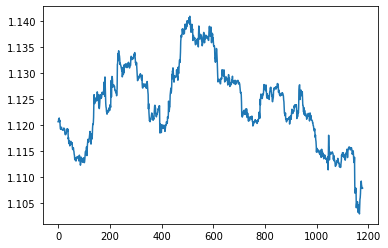

In [30]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

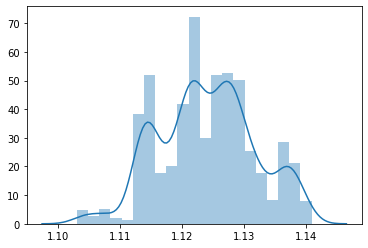

In [31]:
sns.distplot(y_test_np);


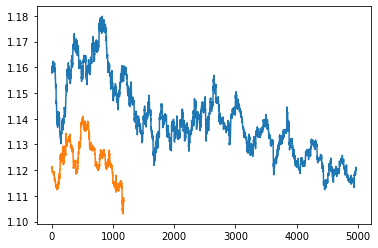

In [32]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [33]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

51
7


In [34]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 120, activation = 'relu'))
#regressior.add(Dropout(0.2))

regressior.add(Dense(units = 1))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [35]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [36]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [37]:
regressior.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 51, 51)            12036     
_________________________________________________________________
lstm_1 (LSTM)                (None, 51, 60)            26880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 51, 80)            45120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               96480     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 180,637
Trainable params: 180,637
Non-trainable params: 0
_________________________________________________________________


In [38]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [540]:
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)



Train on 4972 samples
Epoch 1/100
4972/4972 [==============================] - 36s 7ms/sample - loss: 0.1123 - mean_squared_error: 0.1123 - mean_absolute_error: 0.1456 - mean_absolute_percentage_error: 12.7879 - cosine_proximity: 0.9871
Epoch 2/100
4972/4972 [==============================] - 41s 8ms/sample - loss: 8.9367e-05 - mean_squared_error: 8.9367e-05 - mean_absolute_error: 0.0075 - mean_absolute_percentage_error: 0.6601 - cosine_proximity: 1.0000
Epoch 3/100
4972/4972 [==============================] - 38s 8ms/sample - loss: 2.0240e-05 - mean_squared_error: 2.0240e-05 - mean_absolute_error: 0.0035 - mean_absolute_percentage_error: 0.3088 - cosine_proximity: 1.0000
Epoch 4/100
4972/4972 [==============================] - 28s 6ms/sample - loss: 1.5476e-05 - mean_squared_error: 1.5476e-05 - mean_absolute_error: 0.0031 - mean_absolute_percentage_error: 0.2693 - cosine_proximity: 1.0000
Epoch 5/100
4972/4972 [==============================] - 30s 6ms/sample - loss: 1.1110e-05 - mean

4972/4972 [==============================] - 31s 6ms/sample - loss: 1.9025e-05 - mean_squared_error: 1.9025e-05 - mean_absolute_error: 0.0036 - mean_absolute_percentage_error: 0.3153 - cosine_proximity: 1.0000
Epoch 74/100
4972/4972 [==============================] - 30s 6ms/sample - loss: 1.5372e-05 - mean_squared_error: 1.5372e-05 - mean_absolute_error: 0.0033 - mean_absolute_percentage_error: 0.2856 - cosine_proximity: 1.0000 12s - loss: 1.5064e-05 - mean_squar
Epoch 75/100
4972/4972 [==============================] - 31s 6ms/sample - loss: 8.5214e-06 - mean_squared_error: 8.5214e-06 - mean_absolute_error: 0.0023 - mean_absolute_percentage_error: 0.2045 - cosine_proximity: 1.0000
Epoch 76/100
4972/4972 [==============================] - 32s 6ms/sample - loss: 9.8490e-06 - mean_squared_error: 9.8490e-06 - mean_absolute_error: 0.0025 - mean_absolute_percentage_error: 0.2204 - cosine_proximity: 1.0000
Epoch 77/100
4972/4972 [==============================] - 33s 7ms/sample - loss: 1.42

In [39]:
regressior.save(source_data + "final_model.hdf5")


In [40]:
print(history.history.keys())

NameError: name 'history' is not defined

In [41]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['mean_squared_error'][1:], color = 'red', label = 'MSE')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 360x360 with 0 Axes>

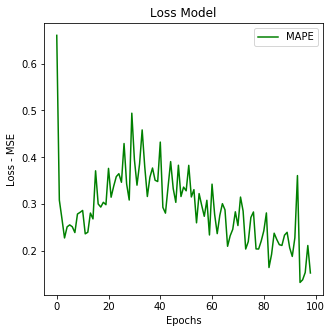

In [581]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_absolute_percentage_error'][1:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [47]:
#Load Model
filepath = os.path.join(source_data, r'final_model_100Epochs_3Dic.hdf5')
#filepath = os.path.join(source_data, r'final_model.hdf5')
print(filepath)
model = tf.keras.models.load_model(filepath)

/Users/marami3/Documents/ITESO/IDI3/proj_deep/final_model_100Epochs_3Dic.hdf5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [48]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(1178, 1)

In [49]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


(4972, 1)

(1178,)
(1178, 1)


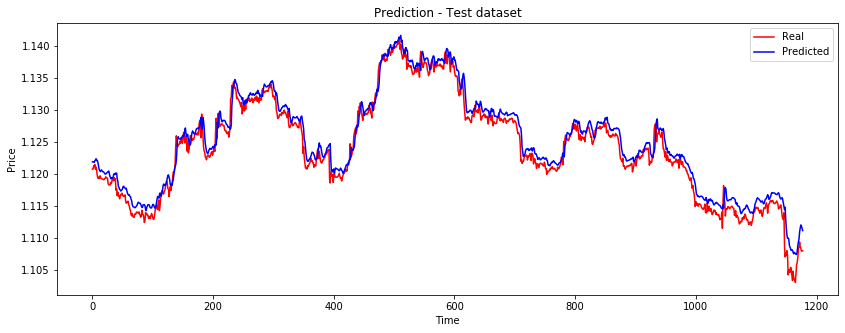

In [50]:
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[:], color = 'red', label = 'Real')
plt.plot(y_test_pred[:], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [51]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [52]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


Test MAE: 0.0012680622453479105
Test RMSE: 0.001557831842551661
Test MSE: 2.4268400496679034e-06
Test MAPE: 0.7701731586280895


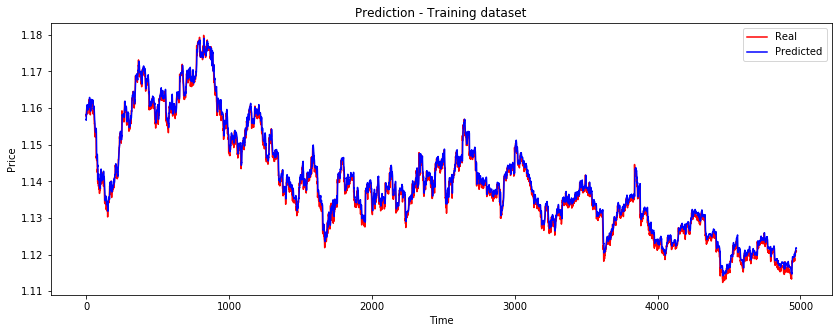

In [53]:

# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np, color = 'red', label = 'Real')
plt.plot(y_train_pred, color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [54]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error


Train MAE: 0.0011967376260765133
Train RMSE: 0.0015686349005414515
Train MSE: 2.460615451196689e-06
Test MAPE: 1.4196069415113224


In [74]:
# Section to implement the ARIMA model from the library statsmodels.tsa.arima_model
# fit model
#model = ARIMA(series, order=(5,1,0))


train, test = y_train_np, y_test_np
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimizat

/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test MSE: 0.000


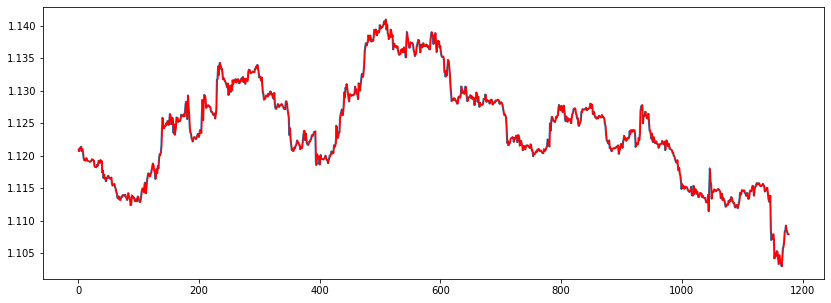

In [75]:
# plot
plt.figure(figsize=(14,5))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [76]:
print('Train MAE:', mean_absolute_error(test, predictions))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(test, predictions)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(test, predictions))#Mean Squared Error

Train MAE: 0.00048750551860369466
Train RMSE: 0.0007395755362077464
Train MSE: 5.469719737569757e-07


Archivo base, donde se separa X y Y correctamente, Y representa el valor Close de la siguiente hora. 
X tiene los historicos. Se separa 5000 para training y el resto para testing. 
